In [1]:
import pandas as pd
from sklearn.linear_model import ElasticNet


In [2]:
train = pd.read_csv('../data/train.gz', index_col="index")
test = pd.read_csv('../data/test.gz', index_col="index")

In [3]:
train.dtypes

chassisType      object
color            object
driveWheels      object
engineVolume    float64
fuelType         object
manufacturer     object
mileage         float64
model            object
modelYear         int64
asking_price    float64
power           float64
dtype: object

In [4]:
def preprocess(df, categorical_features):
    """
    Preprocess a DataFrame for machine learning.

    This function performs the following steps:
    1. Removes rows with missing values (NaN).
    2. Converts specified categorical features into dummy variables (as integers).
    3. Removes all non-numeric columns from the DataFrame.
    4. Separates the target variable ('asking_price') from the features.

    Parameters:
        df (pd.DataFrame): The input DataFrame to preprocess.
        categorical_features (list of str): List of column names to be one-hot encoded.

    Returns:
        train_features (pd.DataFrame): Preprocessed feature DataFrame with numeric columns only.
        train_labels (pd.Series): Target variable ('asking_price') as a pandas Series.
    """
    # Drop rows with missing values
    dataset = df.copy()
    dataset = dataset.dropna()

    # Convert categorical features into dummy variables as integers
    for feature in categorical_features:
        dummies = pd.get_dummies(dataset[feature], prefix=feature, dtype=int)
        dataset = pd.concat([dataset, dummies], axis=1)
        dataset.drop(columns=[feature], inplace=True)

    # Separate the target variable ('asking_price')
    train_labels = dataset.pop('asking_price')

    # Keep only numeric columns for train_features
    train_features = dataset.select_dtypes(include=["number"])

    return train_features, train_labels


In [5]:
train_features, train_labels = preprocess(train, categorical_features=['fuelType','driveWheels','manufacturer', 'chassisType'])
test_features, test_labels = preprocess(test, categorical_features=['fuelType','driveWheels','manufacturer', 'chassisType'])

In [6]:
display(train_features.head())
train_features.shape

,engineVolume,mileage,modelYear,power,fuelType_diesel,fuelType_electricity,fuelType_gasoline,fuelType_hybrid,driveWheels_4wd,driveWheels_fwd,...,manufacturer_volvo,chassisType_convertible,chassisType_coupe,chassisType_hatchback,chassisType_mpv,chassisType_pickup,chassisType_sedan,chassisType_stationwagon,chassisType_suv,chassisType_van
index,,,,,,,,,,,,,,,,,,,,,
0,1.6,56600.0,2011,105.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1.6,29400.0,2012,105.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1.4,21300.0,2014,140.0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1.4,79695.0,2011,122.0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1.2,52500.0,2012,86.0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


(32679, 53)

## Training simple model (Elastic Net)

In [7]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np


In [8]:
alpha = 0.75
l1_ratio = 0.75
random_state = 42
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)
model.fit(train_features, train_labels)

ElasticNet(alpha=0.75, l1_ratio=0.75, random_state=42)

In [9]:
y_train_pred = model.predict(train_features)
y_test_pred = model.predict(test_features)

In [10]:
# Calculate MAPE (Mean Absolute Percentage Error)
train_mape = np.mean(np.abs((train_labels - y_train_pred) / train_labels)) * 100
test_mape = np.mean(np.abs((test_labels - y_test_pred) / test_labels)) * 100

print(f"Training MAPE: {train_mape:.2f}%")
print(f"Validation MAPE: {test_mape:.2f}%")

Training MAPE: 109.45%
Validation MAPE: 114.90%


## Model performance
The model performance measured in MAPE is very weak. But there is some hints in the assignment that one should reflect on the MAPE metric here. It is known for being inflated by extreme values. Lets look at the distribution of absolute percentage errors (APE) for the training set.

In [11]:
inspection = pd.DataFrame({'asking_price': train_labels, 'predicted_price': y_train_pred})
inspection['APE'] = (inspection['asking_price'] - inspection['predicted_price']).abs() / inspection['asking_price'] * 100
inspection.head()

,asking_price,predicted_price,APE
index,,,
0,115937.0,160112.077165,38.102657
1,160837.0,172595.383513,7.310745
2,229886.0,197499.655941,14.088002
3,130500.0,159773.437068,22.431753
4,143937.0,171717.043835,19.300141


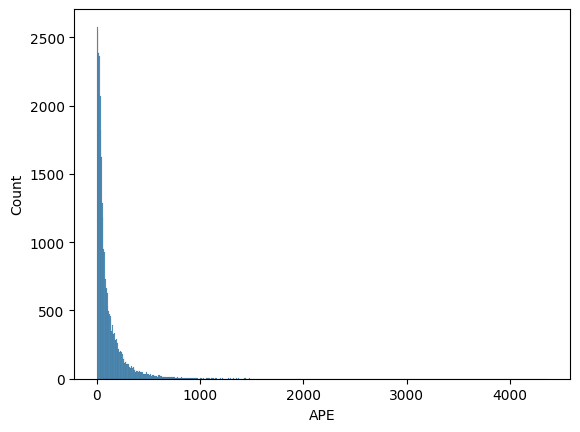

In [12]:
# Plotting the distribution of APE
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(inspection['APE'])
plt.show()


## Looks like some outliers are inflating the metric.
Calculating Median Absolute Percentage Error (MAPE*) in addition to Mean Absolute Percentage Error (MAPE).

In [13]:
# Calculate MAPE* (Median Absolute Percentage Error)
train_mape_ = np.median(np.abs((train_labels - y_train_pred) / train_labels)) * 100
test_mape_ = np.median(np.abs((test_labels - y_test_pred) / test_labels)) * 100

print(f"Training MAPE*: {train_mape_:.2f}%")
print(f"Validation MAPE*: {test_mape_:.2f}%")

Training MAPE*: 53.73%
Validation MAPE*: 57.86%


## Better, but not great.

Exploring some options for utilizing the categorical varibles in the data.

### Weight of Evidence (WoE)

In [14]:
import pandas as pd
import numpy as np

def calculate_woe(df, feature, target):
    """
    Calculates Weight of Evidence (WoE) for a categorical feature.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        feature (str): The categorical feature name.
        target (str): The target variable name (continuous).

    Returns:
        dict: A dictionary containing WoE values for each category in the feature.
        pd.DataFrame: A modified DataFrame with the feature replaced by its WoE values.
    """
    # Calculate overall mean of the target
    overall_mean = df[target].mean()

    # Group by the feature and calculate mean target value for each category
    woe_mapping = (
        df.groupby(feature)
        .agg(mean_target=(target, 'mean'), count=(target, 'size'))
        .assign(woe=lambda x: np.log(x['mean_target'] / overall_mean))
        [['woe']]
        .to_dict()['woe']
    )

    # Replace the feature values in the DataFrame with their WoE equivalents
    df[f"{feature}_woe"] = df[feature].map(woe_mapping)

    return woe_mapping, df

def apply_woe(df, feature, woe_mapping):
    """
    Applies the WoE mapping to a new dataset.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        feature (str): The categorical feature name.
        woe_mapping (dict): The WoE mapping dictionary from `calculate_woe`.

    Returns:
        pd.DataFrame: A modified DataFrame with the feature replaced by its WoE values.
    """
    # Map WoE values to the feature
    df[f"{feature}_woe"] = df[feature].map(woe_mapping).fillna(0)  # Handle unseen categories with 0
    return df

In [15]:
train.dtypes

chassisType      object
color            object
driveWheels      object
engineVolume    float64
fuelType         object
manufacturer     object
mileage         float64
model            object
modelYear         int64
asking_price    float64
power           float64
dtype: object

In [16]:
# Calculate WoE on training data
woe_mapping_manufacturer, train = calculate_woe(train, feature='manufacturer', target='asking_price')
woe_mapping_chassisType, train = calculate_woe(train, feature='chassisType', target='asking_price')
woe_mapping_driveWheels, train = calculate_woe(train, feature='driveWheels', target='asking_price')
woe_mapping_model, train = calculate_woe(train, feature='model', target='asking_price')
woe_mapping_fuelType, train = calculate_woe(train, feature='fuelType', target='asking_price')

print("\nTrain Data with WoE:")
print(train)


test = apply_woe(test, feature='manufacturer', woe_mapping=woe_mapping_manufacturer)
test = apply_woe(test, feature='chassisType', woe_mapping=woe_mapping_chassisType)
test = apply_woe(test, feature='driveWheels', woe_mapping=woe_mapping_driveWheels)
test = apply_woe(test, feature='model', woe_mapping=woe_mapping_model)
test = apply_woe(test, feature='fuelType', woe_mapping=woe_mapping_fuelType)

print("\nTest Data with WoE:")
print(test)



Train Data with WoE:
      chassisType  color driveWheels  engineVolume  fuelType manufacturer  \
index                                                                       
0       hatchback  white         fwd           1.6    diesel         audi   
1       hatchback  black         fwd           1.6    diesel         audi   
2       hatchback    red         fwd           1.4  gasoline         audi   
3       hatchback   grey         fwd           1.4  gasoline         audi   
4       hatchback   grey         fwd           1.2  gasoline         audi   
...           ...    ...         ...           ...       ...          ...   
33585         suv  white         4wd           2.4    diesel        volvo   
33586         suv   grey         4wd           2.4    diesel        volvo   
33587         suv   grey         4wd           2.4    diesel        volvo   
33588         suv  black         4wd           2.4    diesel        volvo   
33589         suv  brown         4wd           2.4    

In [17]:
train.dtypes

chassisType          object
color                object
driveWheels          object
engineVolume        float64
fuelType             object
manufacturer         object
mileage             float64
model                object
modelYear             int64
asking_price        float64
power               float64
manufacturer_woe    float64
chassisType_woe     float64
driveWheels_woe     float64
model_woe           float64
fuelType_woe        float64
dtype: object

In [18]:
train_features, train_labels = preprocess(train, categorical_features=[])
test_features, test_labels = preprocess(test, categorical_features=[])

In [19]:
alpha = 0.75
l1_ratio = 0.75
random_state = 42
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)
model.fit(train_features, train_labels)

ElasticNet(alpha=0.75, l1_ratio=0.75, random_state=42)

In [20]:
y_train_pred = model.predict(train_features)
y_test_pred = model.predict(test_features)

In [21]:
# Calculate MAPE* (Median Absolute Percentage Error)
train_mape_ = np.median(np.abs((train_labels - y_train_pred) / train_labels)) * 100
test_mape_ = np.median(np.abs((test_labels - y_test_pred) / test_labels)) * 100

print(f"Training MAPE*: {train_mape_:.2f}%")
print(f"Validation MAPE*: {test_mape_:.2f}%")

Training MAPE*: 52.46%
Validation MAPE*: 56.86%


In [22]:
train_features

,engineVolume,mileage,modelYear,power,manufacturer_woe,chassisType_woe,driveWheels_woe,model_woe,fuelType_woe
index,,,,,,,,,
0,1.6,56600.0,2011,105.0,0.543434,-0.24004,-0.421977,0.228427,0.214899
1,1.6,29400.0,2012,105.0,0.543434,-0.24004,-0.421977,0.228427,0.214899
2,1.4,21300.0,2014,140.0,0.543434,-0.24004,-0.421977,0.228427,-0.517061
3,1.4,79695.0,2011,122.0,0.543434,-0.24004,-0.421977,0.228427,-0.517061
4,1.2,52500.0,2012,86.0,0.543434,-0.24004,-0.421977,0.228427,-0.517061
...,...,...,...,...,...,...,...,...,...
33585,2.4,209000.0,2010,225.0,0.092476,0.45167,0.429976,1.201463,0.214899
33586,2.4,80100.0,2010,163.0,0.092476,0.45167,0.429976,1.201463,0.214899
33587,2.4,146861.0,2009,163.0,0.092476,0.45167,0.429976,1.201463,0.214899
